In [7]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

### Gradient boost guided example

Having walked through gradient boost by hand, now let's try it with SKlearn.  We'll still use the European Social Survey Data, but now with a categorical outcome: Whether or not someone lives with a partner.

In [8]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

Since we're now working with a binary outcome, we've switched to a classifier.  Now our loss function can't be the residuals.  Our options are "deviance", or "exponential".  Deviance is used for logistic regression, and we'll try that here.

In [9]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.04650845608292417
Percent Type II errors: 0.17607746863066012

Test set accuracy:
Percent Type I errors: 0.06257668711656442
Percent Type II errors: 0.18527607361963191


Unlike decision trees, gradient boost solutions are not terribly easy to interpret on the surface.  But they aren't quite a black box.  We can get a measure of how important various features are by counting how many times a feature is used over the course of many decision trees.

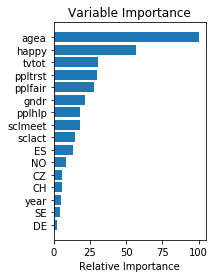

In [10]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [11]:
clf.score(X_test, y_test)

0.7521472392638037

It appears that age and happiness are the most important features in predicting whether or not someone lives with a partner.

### DRILL: Improve this gradient boost model

While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement.  Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set.  Strategies you might use include:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

Have fun!

In [12]:
df.head()

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1.0
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1.0
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,2.0
3,CH,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1.0
4,CH,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1.0


In [13]:
import seaborn as sns

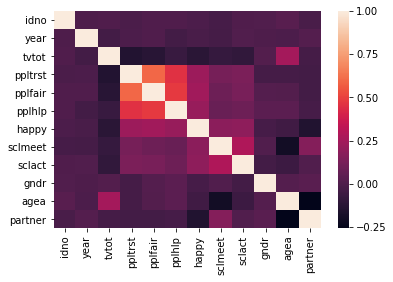

In [14]:
sns.heatmap(df.corr())

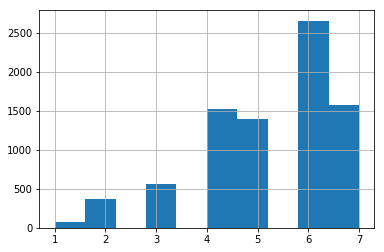

In [15]:
df.sclmeet.hist()

In [16]:
# Let's start with some new features. We're dealing with a very low correlation between features.

# let's try to create some new ones
df_new = df.copy()

In [17]:

df_new["male"] = df_new["gndr"].apply(lambda value: int(value - 1))
df_new = df_new.drop(columns=["gndr"])
# maybe people who have a high trust score are also happy?
df_new["happy_trust"] = df["ppltrst"] * df["happy"]

# maybe people who are happy don't watch a lot of tv?
df_new["happy_tv"] = df["happy"] * df["tvtot"]

# let's normalize age to be more in line with the range of values for the other datapoint
df_new["normalized_age"] = df["agea"] / 10

# drop the year column, it's probably noise
df_new = df_new.drop(columns=["year", "idno"])

# create an interaction between trust, help and fairness, which could very well help explain some more variance
df_new["trust_help_fair"] = df.pplfair * df.pplhlp * df.ppltrst

# create a feature for social meetup and happiness. Maybe people who are social are more likely to have a partner,
# but also be happy
df_new["social_happy"] = df.sclmeet * df.happy

# re-shape the partner variable
df_new["partner"] = df["partner"] - 1


# create the dummies for country
df_new = pd.concat([df_new, pd.get_dummies(df_new['cntry'])], axis=1)


In [18]:
df_new.head()

,cntry,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,agea,partner,...,happy_tv,normalized_age,trust_help_fair,social_happy,CH,CZ,DE,ES,NO,SE
0,CH,3.0,3.0,10.0,5.0,8.0,5.0,4.0,60.0,0.0,...,24.0,6.0,150.0,40.0,1,0,0,0,0,0
1,CH,6.0,5.0,7.0,5.0,9.0,3.0,2.0,59.0,0.0,...,54.0,5.9,175.0,27.0,1,0,0,0,0,0
2,CH,1.0,8.0,8.0,8.0,7.0,6.0,3.0,24.0,1.0,...,7.0,2.4,512.0,42.0,1,0,0,0,0,0
3,CH,4.0,6.0,6.0,7.0,10.0,6.0,2.0,64.0,0.0,...,40.0,6.4,252.0,60.0,1,0,0,0,0,0
4,CH,5.0,6.0,7.0,5.0,8.0,7.0,2.0,55.0,0.0,...,40.0,5.5,210.0,56.0,1,0,0,0,0,0


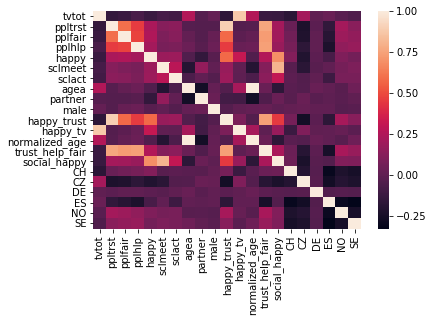

In [19]:
# do a heatmap to see what's going on in terms of correlation
sns.heatmap(df_new.corr())

In [20]:
features = df_new.drop(columns=[
    "partner",
    "cntry"
])

target = df_new["partner"]

In [21]:
# create a function to measure the relative importance of features
def show_important_features(model, features):
    feature_importance = model.feature_importances_

    # Make importances relative to max importance.
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.subplot(1, 2, 2)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, features.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()

In [22]:
# create a function that shows us the error we received
def show_error(model, X_train, X_test, y_train, y_test):
    predict_train = model.predict(X_train)
    predict_test = model.predict(X_test)

    # Accuracy tables.
    table_train = pd.crosstab(y_train, predict_train, margins=True)
    table_test = pd.crosstab(y_test, predict_test, margins=True)

    train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
    train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

    test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
    test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

    print((
        'Training set accuracy:\n'
        'Percent Type I errors: {}\n'
        'Percent Type II errors: {}\n\n'
        'Test set accuracy:\n'
        'Percent Type I errors: {}\n'
        'Percent Type II errors: {}'
    ).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))



In [44]:
# create the second model

# 1) Split to train / test split
# 2) Build and run model

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state=10)


# create model
params = {'n_estimators': 10000,
          'max_depth': 1,
          'loss': 'exponential'}

gbc = ensemble.GradientBoostingClassifier(**params)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='exponential', max_depth=1,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10000,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [45]:
show_error(gbc, X_train, X_test, y_train, y_test)

Training set accuracy:
Percent Type I errors: 0.05223677032187671
Percent Type II errors: 0.18985270049099837

Test set accuracy:
Percent Type I errors: 0.06134969325153374
Percent Type II errors: 0.18895705521472392


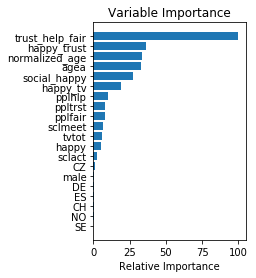

In [46]:
show_important_features(gbc, features)

In [47]:
gbc.score(X_test, y_test)

0.7496932515337423

In [48]:
# test a random forrest classifier
rfc = ensemble.RandomForestClassifier(n_estimators=20, criterion="entropy")
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [49]:
rfc.score(X_test, y_test)

0.7398773006134969